In [1]:
import mysql.connector
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_similarity

import os 

In [2]:
# Membuat koneksi ke database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='tourista_db'
)

In [3]:
# Mengeksekusi query untuk mengambil data dari tabel

query = "SELECT * FROM destination"
destination = pd.read_sql_query(query, conn)

query = "SELECT * FROM review_wisata"
ratings = pd.read_sql_query(query, conn)

query = "SELECT * FROM user_profile"
users = pd.read_sql_query(query, conn)

C:\Users\dewan\AppData\Local\Temp\ipykernel_19508\707316895.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  destination = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_19508\707316895.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_19508\707316895.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  users = pd.read_sql_query(query, conn)


In [4]:
ratings = ratings.sort_values('wisata_rating', ascending=False).drop_duplicates(subset=['wisata_id', 'user_wisata'], keep='first')

In [5]:
train, test = train_test_split(ratings, test_size = 0.2)

### load pre trained model

In [2]:
model =  tf.keras.models.load_model('pretrained_collab_rec')

In [3]:
tf.keras.models.save_model(model, '../app/model/pretrained_collab_rec')

INFO:tensorflow:Assets written to: ../app/model/pretrained_collab_rec\assets


INFO:tensorflow:Assets written to: ../app/model/pretrained_collab_rec\assets


In [7]:
# calculations for "haversine distance" and complementary functions for collaborative filtering
from math import radians

def haversine_distance(lat1, long1, lat2, long2):
    earth_radius = 6371  # Radius of the Earth in kilometers (source: google)
    lat1_rad = np.radians(lat1)
    long1_rad = np.radians(long1)
    lat2_rad = np.radians(lat2)
    long2_rad = np.radians(long2)
    diff_lat = lat2_rad - lat1_rad
    diff_long = long2_rad - long1_rad
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

def filter_by_location(destination, user_lat, user_long, max_distance):
    destination['distance'] = haversine_distance(destination['destination_lat'], destination['destination_long'], user_lat, user_long)
    destination = destination[destination['distance'] <= max_distance]
    destination = destination.drop('distance', axis=1)
    return destination

def filter_by_city(destination):
    city_filter = ['Jakarta', 'Bandung', 'Yogyakarta', 'Semarang', 'Surabaya']
    destination = destination[destination['city'].isin(city_filter)]
    return destination

In [8]:
# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, u_lat, u_long, np_val = 6 ):
    """
        User_Id : untuk melakukan rekomendasi berdasarkan User_Id yang diberikan
        destinatin : dataframe dengan format column terdapat "user_wisata, wisata_id, wisata_rating, name_wisata, category, description_wisata, destination_lat, destination_long, destination_photo, city"
        model : model hasil yang sudah di training sebelumnya
        np_val : banyaknya output yang akan diberikan
        u_lat & u_long : berguna untuk menentukan destinasi wisata terdekat dari lat & long yang diberikan
    """
    
    if User_Id in ratings['user_wisata'].values:
            destination = destination.copy()
            user_ids = np.array([User_Id] * len(destination))
            results = model([destination.id.values, user_ids]).numpy().reshape(-1)
    
            destination['predicted_rating'] = pd.Series(results)
            destination = filter_by_location(destination, u_lat, u_long, 30)[:20]
            destination = destination.sort_values('predicted_rating', ascending = False)
    else:
            destination = destination.copy()
            destination = destination.sort_values('rating', ascending = False)  
    
    return destination[['name_wisata', 'city','coordinate', 'destination_photo','description_wisata', 'predicted_rating']][:np_val].to_dict(orient='records')

In [9]:
user_location = 'Bandung'
user_lat = -6.1253
user_long = 106.8335

In [11]:
final_result = collaborative_rec(34, destination, model, user_lat, user_long, )
final_result

[{'name_wisata': 'Jembatan Kota Intan',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.1314572, 'lng': 106.8106169}",
  'destination_photo': 'lala.png',
  'description_wisata': 'Jembatan Kota Intan adalah jembatan tertua di Indonesia yang dibangun pada tahun 1628 oleh pemerintah Vereenigde Oostindische Compagnie atau VOC, atau masyarakat kita lebih familiar dengan sebutan Kumpeni. Jembatan itu kini terletak di Kali Besar kawasan ',
  'predicted_rating': 4.536832332611084},
 {'name_wisata': 'Museum Nasional',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.176402099999999, 'lng': 106.8215901}",
  'destination_photo': 'lala.png',
  'description_wisata': 'Museum Nasional Republik Indonesia atau Museum Gajah, adalah sebuah museum arkeologi, sejarah, etnografi, dan geografi yang terletak di Jakarta Pusat dan persisnya di Jalan Merdeka Barat 12. Museum ini merupakan museum pertama dan terbesar di Asia Tenggar',
  'predicted_rating': 4.045568466186523},
 {'name_wisata': 'Atlantis Water Adv

### try to train again

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error') 

In [14]:
model.fit(x= [train.wisata_id, train.user_wisata], 
                    y= train.wisata_rating, 
                    validation_data = ([train.wisata_id, train.user_wisata], train.wisata_rating), 
                    epochs =10,
                    callbacks=[early_stopping],)

Epoch 1/10
240/240 [==============================] - 2s 4ms/step - loss: 1.0296 - val_loss: 0.5938
Epoch 2/10
240/240 [==============================] - 1s 3ms/step - loss: 1.0166 - val_loss: 0.5626
Epoch 3/10
240/240 [==============================] - 1s 3ms/step - loss: 0.9796 - val_loss: 0.5364
Epoch 4/10
240/240 [==============================] - 1s 3ms/step - loss: 0.9512 - val_loss: 0.5142
Epoch 5/10
240/240 [==============================] - 1s 3ms/step - loss: 0.9264 - val_loss: 0.4945
Epoch 6/10
240/240 [==============================] - 1s 3ms/step - loss: 0.9018 - val_loss: 0.4764
Epoch 7/10
240/240 [==============================] - 1s 3ms/step - loss: 0.8912 - val_loss: 0.4601
Epoch 8/10
240/240 [==============================] - 1s 3ms/step - loss: 0.8823 - val_loss: 0.4464
Epoch 9/10
240/240 [==============================] - 1s 3ms/step - loss: 0.8735 - val_loss: 0.4315
Epoch 10/10
240/240 [==============================] - 1s 3ms/step - loss: 0.8607 - val_loss: 0.4178

In [20]:
history = model.fit(x= [train.wisata_id, train.user_wisata], 
                    y= train.wisata_rating, 
                    validation_data = ([train.wisata_id, train.user_wisata], train.wisata_rating), 
                    epochs =50,
                    callbacks=[early_stopping],)

Epoch 1/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5671 - val_loss: 0.1023
Epoch 2/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5441 - val_loss: 0.1020
Epoch 3/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5585 - val_loss: 0.0999
Epoch 4/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5637 - val_loss: 0.0985
Epoch 5/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5492 - val_loss: 0.0985
Epoch 6/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5679 - val_loss: 0.0977
Epoch 7/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5440 - val_loss: 0.0974
Epoch 8/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5572 - val_loss: 0.0962
Epoch 9/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5437 - val_loss: 0.0968
Epoch 10/50
240/240 [==============================] - 1s 3ms/step - loss: 0.5510 - val_loss: 0.0963

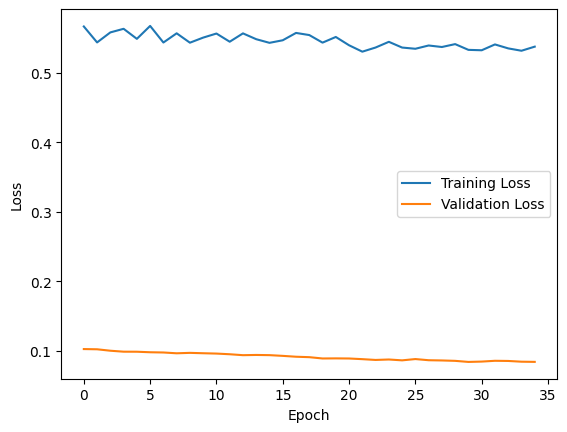

In [21]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
final_result = collaborative_rec(34, destination, model, user_lat, user_long, )
final_result

[{'name_wisata': 'Jembatan Kota Intan',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.1314572, 'lng': 106.8106169}",
  'destination_photo': 'lala.png',
  'description_wisata': 'Jembatan Kota Intan adalah jembatan tertua di Indonesia yang dibangun pada tahun 1628 oleh pemerintah Vereenigde Oostindische Compagnie atau VOC, atau masyarakat kita lebih familiar dengan sebutan Kumpeni. Jembatan itu kini terletak di Kali Besar kawasan ',
  'predicted_rating': 4.668848037719727},
 {'name_wisata': 'Atlantis Water Adventure',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.12419, 'lng': 106.839134}",
  'destination_photo': 'lala.png',
  'description_wisata': 'Atlantis Water Adventure atau dikenal dengan Atlantis Ancol akan menyuguhkan petualangan wisata air tak terlupakan. Tempat Wisata bertemakan permainan air dengan luas 5 hektar ini memberi sensasi petualangan di 8 kolam utama. Yaitu kolam Antila, Plaza Atl',
  'predicted_rating': 4.077054023742676},
 {'name_wisata': 'Museum Wayang',
  'c

In [16]:
if 20 in ratings['user_wisata'].values:
    print("true")
else:
    print("false")

true
